# Outlier detections using Kmeans clustering

In [6]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import pyleoclim as pyleo
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import scipy
import pandas as pd
import matplotlib.colors as mcolors
import random

This follows the recipe of: https://towardsdev.com/outlier-detection-using-k-means-clustering-in-python-214188fc90e8

## Generate timeseries

Let's generate a series with known periodicties, colored noise and 6 outliers. 

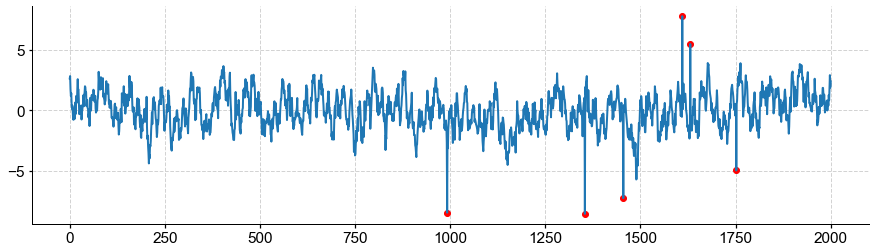

In [2]:
# Use a periodic signal as a base

freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add colored noise

t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)

noisy_sig = signal + (v-np.mean(v))/np.std(v)

outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))

#set the outliers
nbr_out=6 #just add 6 random outliers
index = np.random.randint(0,len(noisy_sig),nbr_out) #Index on the time series
out_index = np.random.randint(0,len(outlier_values),nbr_out)
val_out=outlier_values[out_index]
time_out = time[index]

signal_out = np.copy(noisy_sig)
for idx,item in enumerate(index):
    signal_out[item] = val_out[idx]

fig=plt.figure(figsize=(15,4))
plt.plot(time,signal_out)
plt.scatter(time_out,outlier_values[out_index],color='r')

In [3]:
np.sort(index)

array([ 992, 1354, 1455, 1610, 1631, 1752])

## K-means algorithm

In [5]:
ys=(signal_out-np.mean(signal_out))/np.std(signal_out)
km=KMeans(n_clusters=2)
model=km.fit(ys.reshape(-1, 1))

In [6]:
set(model.labels_)

{0, 1}

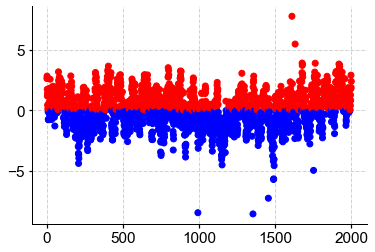

In [7]:
colors=['b','r']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(time, signal_out, c=vectorizer(model.labels_))

### Using silhouette to obtain k automatically

Tutorial: https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/?

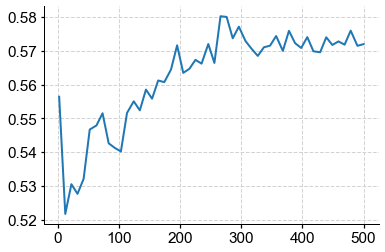

In [8]:
range_n_clusters = np.linspace(2,len(ys)/4,50,dtype='int')
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(ys.reshape(-1, 1))
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(ys.reshape(-1, 1), cluster_labels))

plt.plot(range_n_clusters,np.array(silhouette_avg))

In [10]:
cl=range_n_clusters[np.argmax(silhouette_avg)]
cl

266

Let's use a more reasonable number of clusters:

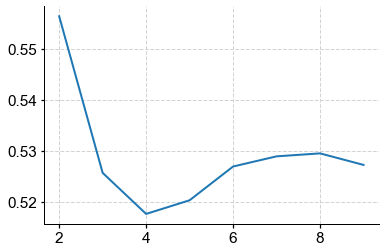

In [13]:
range_n_clusters = np.arange(2,10,1,dtype='int')
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(ys.reshape(-1, 1))
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(ys.reshape(-1, 1), cluster_labels))

plt.plot(range_n_clusters,np.array(silhouette_avg))

In [14]:
cl=range_n_clusters[np.argmax(silhouette_avg)]
cl


2

It wouldn't be surprising that k=2 should be good enough for all applications, allowing to deal with outliers below and above the main curve. 266 clusters may not make a lot of sense. 

In [9]:
center=model.cluster_centers_[model.labels_,0]
set(center)

{-0.782739301236472, 0.7977464119564448}

In [8]:
distance=np.sqrt((ys-center)**2)
distance

array([0.94709505, 1.07880241, 0.35525967, ..., 1.13078037, 0.44996549,
       0.79060003])

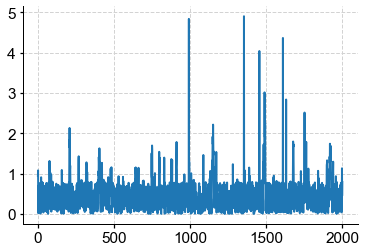

In [10]:
plt.plot(distance)

In [11]:
threshold = 2
np.argwhere(distance>threshold)

array([[ 208],
       [ 992],
       [1151],
       [1354],
       [1455],
       [1488],
       [1489],
       [1490],
       [1493],
       [1610],
       [1631],
       [1752]])

In [12]:
threshold = 3
np.argwhere(distance>threshold)

array([[ 992],
       [1354],
       [1455],
       [1489],
       [1610]])

Note that this requires for the signal to be detrended, or not have large trends in the data. 

### Detrended Signal

<AxesSubplot:xlabel='time', ylabel='value'>

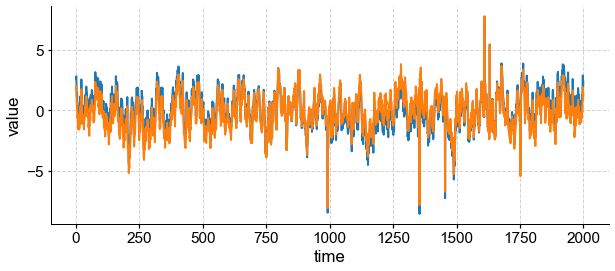

In [23]:
ts=pyleo.Series(time,signal_out)
ts_detrend=ts.detrend()

fig,ax=ts.plot()
ts_detrend.plot(ax=ax)

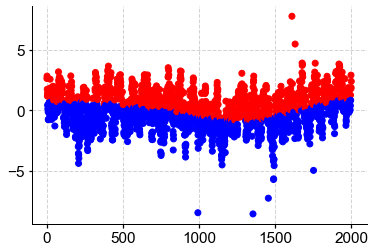

In [24]:
ds=ts_detrend.value
ys=(ds-np.mean(ds))/np.std(ds)
km=KMeans(n_clusters=2)
model=km.fit(ys.reshape(-1, 1))

colors=['b','r']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

plt.scatter(time, signal_out, c=vectorizer(model.labels_))

In [25]:
center=model.cluster_centers_[model.labels_,0]
distance=np.sqrt((ys-center)**2)
distance

array([0.53930378, 0.67555044, 0.07386627, ..., 0.60872301, 0.09634972,
       0.25636598])

In [29]:
set(center)

{-0.7574699916063385, 0.8279875954274308}

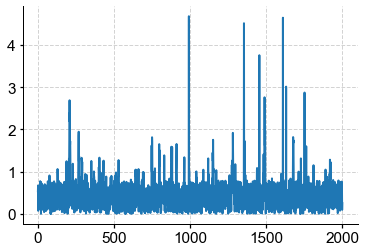

In [26]:
plt.plot(distance)

In [27]:
threshold = 3
np.argwhere(distance>threshold)

array([[ 992],
       [1354],
       [1455],
       [1610],
       [1631]])

### with our automated k


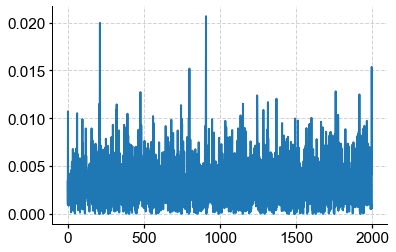

In [12]:
km=KMeans(n_clusters=266)
model=km.fit(ys.reshape(-1, 1))
center=model.cluster_centers_[model.labels_,0]

distance=np.sqrt((ys-center)**2)
plt.plot(distance)

Still need to define a threshold for these values

## Automated outlier detection

In [2]:
def detect_outliers_kmeans(ys, nbr_cluster = None, max_cluster = 10, threshold=3):
    
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    print("Optimizing for the best number of clusters, this may take a few minutes")
    
    # run with either one cluster number of several
    if nbr_cluster is not None:
        if type(nbr_cluster) == list:
            range_n_clusters = nbr_cluster
        else:
            range_n_clusters = [nbr_cluster]
    else:
        range_n_clusters = np.arange(2,max_cluster+1,1,dtype='int')
    silhouette_avg = []
    idx_out=[]
    
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(ys.reshape(-1, 1))
        silhouette_avg.append(silhouette_score(ys.reshape(-1, 1), kmeans.labels_))
        center=kmeans.cluster_centers_[kmeans.labels_,0]
        distance=np.sqrt((ys-center)**2)
        idx_out.append(np.argwhere(distance>threshold).reshape(1,-1)[0])
    
    res = pd.DataFrame({'number of clusters':range_n_clusters, 'silhouette score':silhouette_avg,'outlier indices':idx_out})
    res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]

    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res

def plot_outliers(ts,ys,indices, figsize=[10,4]):
    fig,ax = plt.subplots(figsize=figsize)
    pyleo.utils.plotting.plot_scatter_xy(ts,ys,ts[indices],ys[indices],ax=ax)

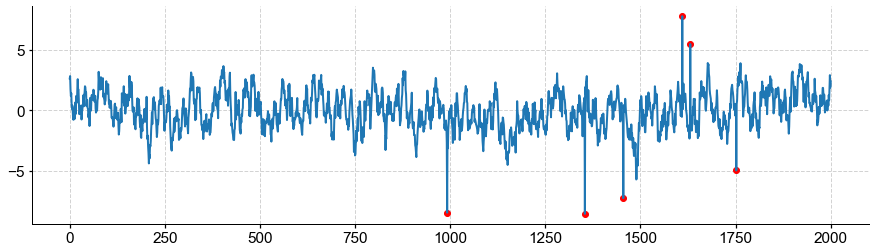

In [3]:
# Generate a mixed signal with known frequencies
freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add colored noise

t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)

noisy_sig = signal + (v-np.mean(v))/np.std(v)

outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))

#set the outliers
nbr_out=6 #just add 6 random outliers
index = np.random.randint(0,len(noisy_sig),nbr_out) #Index on the time series
out_index = np.random.randint(0,len(outlier_values),nbr_out)
val_out=outlier_values[out_index]
time_out = time[index]

signal_out = np.copy(noisy_sig)
for idx,item in enumerate(index):
    signal_out[item] = val_out[idx]

fig=plt.figure(figsize=(15,4))
plt.plot(time,signal_out)
plt.scatter(time_out,outlier_values[out_index],color='r')

In [21]:
%%time
indices, res = detect_outliers_kmeans(signal_out)

Optimizing for the best number of clusters, this may take a few minutes
CPU times: user 7.49 s, sys: 861 ms, total: 8.35 s
Wall time: 1.38 s


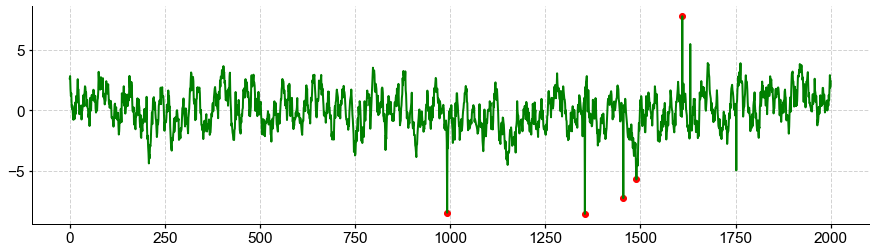

In [22]:
plot_outliers(time,signal_out,indices,figsize=(15,4))

### Series with no outliers

In [23]:
%%time
indices, res = detect_outliers_kmeans(noisy_sig)

Optimizing for the best number of clusters, this may take a few minutes
CPU times: user 6.37 s, sys: 1.01 s, total: 7.38 s
Wall time: 1.38 s


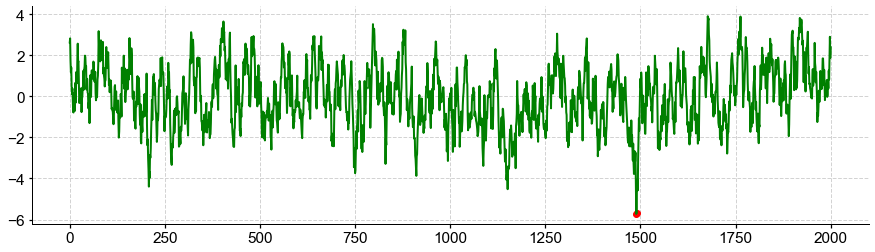

In [24]:
plot_outliers(time,noisy_sig,indices,figsize=(15,4))

### Series with shift

In [4]:
def create_shift_signal(shift_value=3):
    freqs=[1/20,1/80]
    time=np.arange(2001)
    signals=[]
    for freq in freqs:
        signals.append(np.cos(2*np.pi*freq*time))
    signal=sum(signals)

    # Add colored noise

    t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)
    noisy_sig = signal + (v-np.mean(v))/np.std(v)
    
    # Add outliers
    out_indices = [350, 1482, 1982, 1156, 750, 982]
    outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
    outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
    vals = np.arange(outliers_start,outliers_end,0.1)
    outlier_values=np.concatenate((vals,-vals))
    out_vals=outlier_values[[2,26,40,56,69,78]]
    time_out = time[out_indices]
    
    signal_out = np.copy(noisy_sig)
    for idx,item in enumerate(out_indices):
        signal_out[item] = out_vals[idx]

    signal_shift=np.copy(signal_out)
    signal_shift[400:478]=signal_out[400:478]+shift_value
    
    return time,signal_shift

#### Let the algorithm decide on the best number of clusters:

In [14]:
shift_value_list = [-10,-7,-5,-3,3,5,7,10]

nbr_cluster = []

for item in shift_value_list:
    time,ys=create_shift_signal(item)
    idx,res = detect_outliers_kmeans(ys)
    nbr_cluster.append(int(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['number of clusters']))

Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes
Optimizing for the best number of clusters, this may take a few minutes


In [15]:
nbr_cluster

[2, 3, 2, 2, 2, 3, 2, 2]

Let's have a look at the clusters in more details:

In [5]:
def detect_outliers_kmeans_plot(ys, ts, nbr_cluster = None, max_cluster = 10, threshold=3):
    
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    print("Optimizing for the best number of clusters, this may take a few minutes")
    
    # run with either one cluster number of several
    if nbr_cluster is not None:
        if type(nbr_cluster) == list:
            range_n_clusters = nbr_cluster
        else:
            range_n_clusters = [nbr_cluster]
    else:
        range_n_clusters = np.arange(2,max_cluster+1,1,dtype='int')
    silhouette_avg = []
    idx_out=[]
    
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(ys.reshape(-1, 1))
        silhouette_avg.append(silhouette_score(ys.reshape(-1, 1), kmeans.labels_))
        center=kmeans.cluster_centers_[kmeans.labels_,0]
        distance=np.sqrt((ys-center)**2)
        idx_out.append(np.argwhere(distance>threshold).reshape(1,-1)[0])
    
    res = pd.DataFrame({'number of clusters':range_n_clusters, 'silhouette score':silhouette_avg,'outlier indices':idx_out})
    res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]

    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    # make a plot of the clusters
    nbr_cl = int(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['number of clusters'])
    kmeans = KMeans(n_clusters=nbr_cl)
    kmeans.fit(ys.reshape(-1, 1))
    colors_list = ['r','b','k','g']
    colors = colors_list[0:nbr_cl]
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

    plt.scatter(ts, ys, c=vectorizer(kmeans.labels_))
    plt.scatter(ts[indices],ys[indices],c='m')
    plt.show()
    
    return indices, res

Optimizing for the best number of clusters, this may take a few minutes


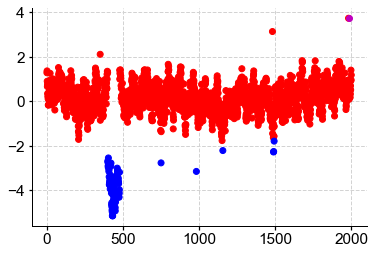

Optimizing for the best number of clusters, this may take a few minutes


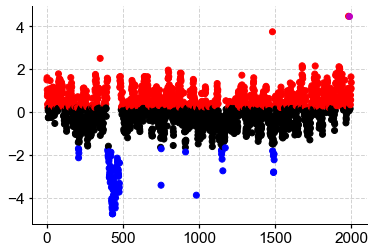

Optimizing for the best number of clusters, this may take a few minutes


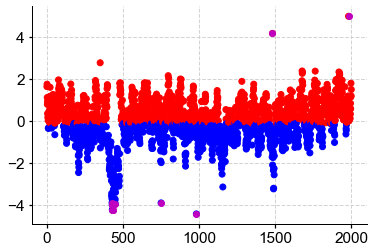

Optimizing for the best number of clusters, this may take a few minutes


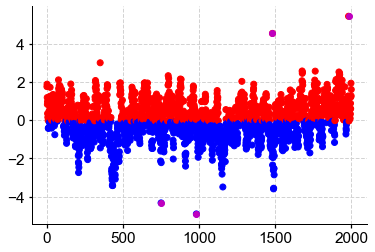

Optimizing for the best number of clusters, this may take a few minutes


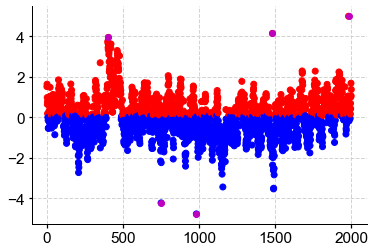

Optimizing for the best number of clusters, this may take a few minutes


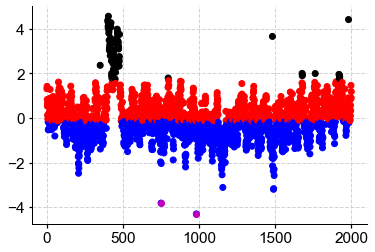

Optimizing for the best number of clusters, this may take a few minutes


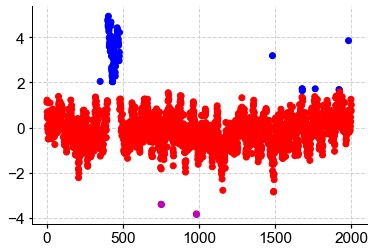

Optimizing for the best number of clusters, this may take a few minutes


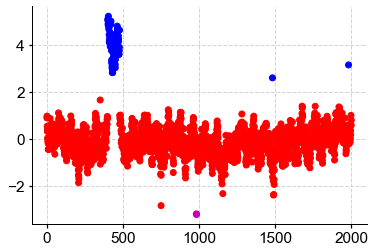

In [25]:
shift_value_list = [-10,-7,-5,-3,3,5,7,10]

for item in shift_value_list:
    ts,ys=create_shift_signal(item)
    idx,res = detect_outliers_kmeans_plot(ys,ts)

#### Impose three clusters:

Optimizing for the best number of clusters, this may take a few minutes


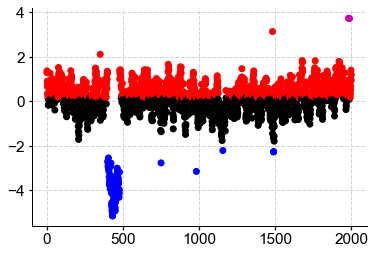

Optimizing for the best number of clusters, this may take a few minutes


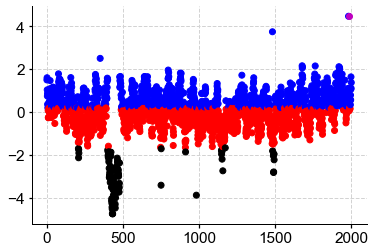

Optimizing for the best number of clusters, this may take a few minutes


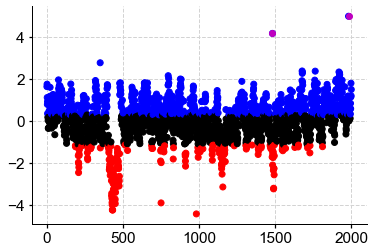

Optimizing for the best number of clusters, this may take a few minutes


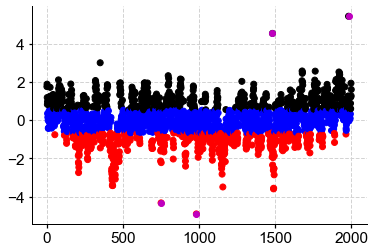

Optimizing for the best number of clusters, this may take a few minutes


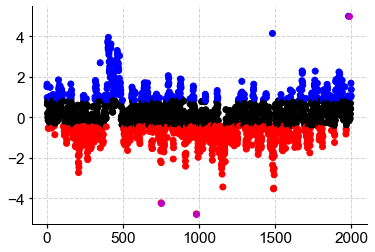

Optimizing for the best number of clusters, this may take a few minutes


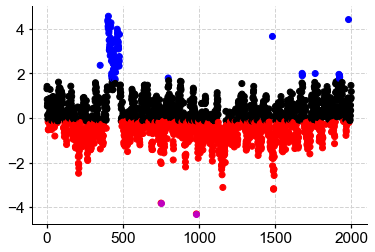

Optimizing for the best number of clusters, this may take a few minutes


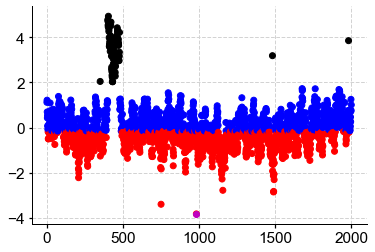

Optimizing for the best number of clusters, this may take a few minutes


IndexError: arrays used as indices must be of integer (or boolean) type

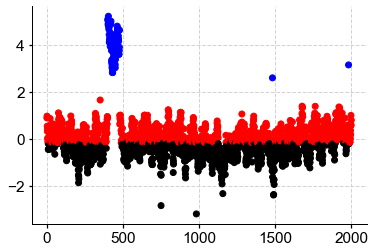

In [37]:
shift_value_list = [-10,-7,-5,-3,3,5,7,10]

for item in shift_value_list:
    ts,ys=create_shift_signal(item)
    idx,res = detect_outliers_kmeans_plot(ys,ts,nbr_cluster=3 )

The "anomaly" behaves as a cluster, which we would expect; therefore no outliers are detected since the outlier points are within the same value of the anomalies.

#### Impose two clusters:

Optimizing for the best number of clusters, this may take a few minutes


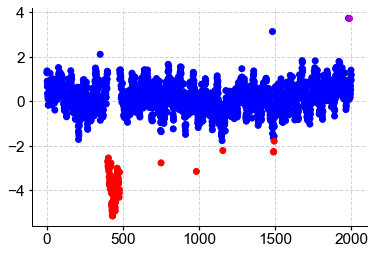

Optimizing for the best number of clusters, this may take a few minutes


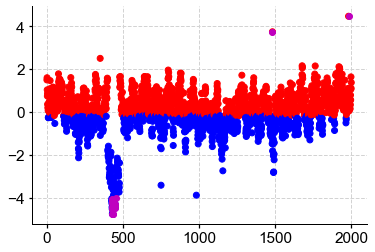

Optimizing for the best number of clusters, this may take a few minutes


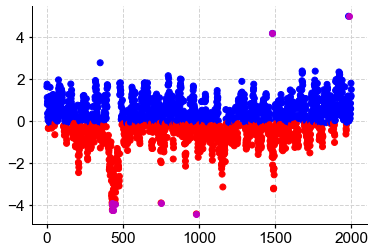

Optimizing for the best number of clusters, this may take a few minutes


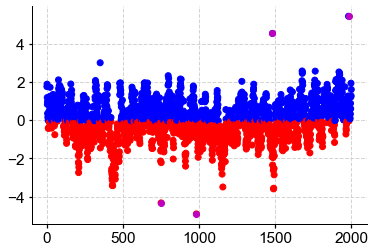

Optimizing for the best number of clusters, this may take a few minutes


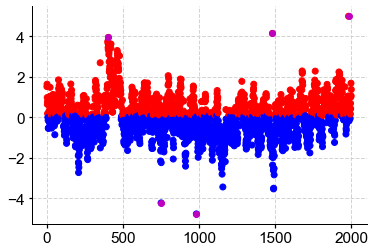

Optimizing for the best number of clusters, this may take a few minutes


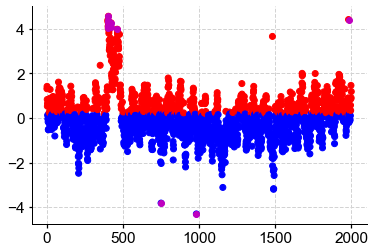

Optimizing for the best number of clusters, this may take a few minutes


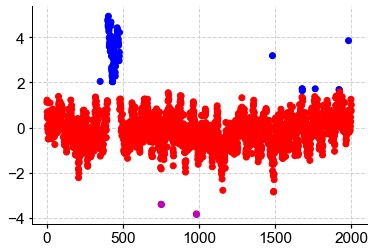

Optimizing for the best number of clusters, this may take a few minutes


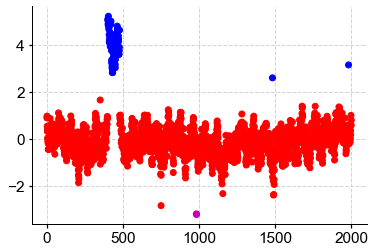

In [7]:
shift_value_list = [-10,-7,-5,-3,3,5,7,10]

for item in shift_value_list:
    ts,ys=create_shift_signal(item)
    idx,res = detect_outliers_kmeans_plot(ys,ts,nbr_cluster=2)

This catches a few more of the true one-point outlier values.

### Re-work algorithm as to output clusters

In [78]:
def detect_outliers_kmeans(ys, nbr_cluster = None, max_cluster = 10, threshold=3):
    
    
    ys=pyleo.utils.tsutils.standardize(ys)[0] # standardization is key for the alogrithm to work.
    ys=np.array(ys)
    
    print("Optimizing for the best number of clusters, this may take a few minutes")
    
    # run with either one cluster number of several
    if nbr_cluster is not None:
        if type(nbr_cluster) == list:
            range_n_clusters = nbr_cluster
        else:
            range_n_clusters = [nbr_cluster]
    else:
        range_n_clusters = np.arange(2,max_cluster+1,1,dtype='int')
    silhouette_avg = []
    idx_out=[]
    clusters = []
    
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(ys.reshape(-1, 1))
        silhouette_avg.append(silhouette_score(ys.reshape(-1, 1), kmeans.labels_))
        center=kmeans.cluster_centers_[kmeans.labels_,0]
        distance=np.sqrt((ys-center)**2)
        idx_out.append(np.argwhere(distance>threshold).reshape(1,-1)[0])
        clusters.append(kmeans.labels_)
    
    res = pd.DataFrame({'number of clusters':range_n_clusters, 'silhouette score':silhouette_avg,'outlier indices':idx_out,'clusters':clusters})
    res_sil = res.loc[res['silhouette score']==np.max(res['silhouette score'])]

    unique_idx = list(res_sil['outlier indices'].iloc[0])
    
    if res_sil.shape[0]>1:
        for idx,row in res_sil.iterrows():
            for item in row['outlier indices']:
                if item not in unique_idx:
                    unique_idx.append(item)
            
    indices = np.array(unique_idx)
    
    return indices, res

def plot_outliers(ts,ys,indices, figsize=[10,4]):
    fig,ax = plt.subplots(figsize=figsize)
    if np.size(indices) != 0:
        pyleo.utils.plotting.plot_scatter_xy(ts,ys,ts[indices],ys[indices],ax=ax)
    else:
        pyleo.utils.plotting.plot_xy(ts,ys,ax=ax)

def plot_clusters(ts, ys, clusters, indices, figsize=[10,4]):
    fig,ax = plt.subplots(figsize=figsize)
    color_list = list(mcolors.CSS4_COLORS.keys())
    color_list.remove('red')
    random.Random(9).shuffle(color_list)
    colors = color_list[0:len(np.unique(clusters))] 
    vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
    plt.scatter(ts, ys, c=vectorizer(clusters))
    if np.size(indices) != 0:
        plt.scatter(ts[indices],ys[indices],c='red')
    plt.show()
    

Test:

Optimizing for the best number of clusters, this may take a few minutes


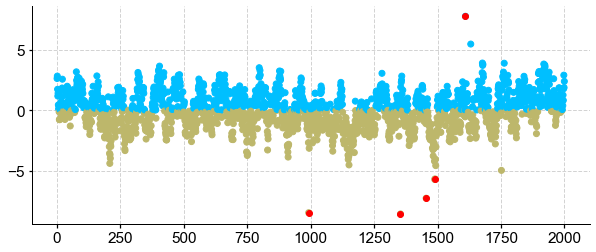

In [38]:
# Use a periodic signal as a base

freqs=[1/20,1/80]
time=np.arange(2001)
signals=[]
for freq in freqs:
    signals.append(np.cos(2*np.pi*freq*time))
signal=sum(signals)

# Add colored noise

t,v = pyleo.utils.gen_ts(model='colored_noise',nt=len(time),seed=1983)

noisy_sig = signal + (v-np.mean(v))/np.std(v)

outliers_start = np.mean(noisy_sig)+3*np.std(noisy_sig)
outliers_end = np.mean(noisy_sig)+6*np.std(noisy_sig)
vals = np.arange(outliers_start,outliers_end,0.1)
outlier_values=np.concatenate((vals,-vals))

#set the outliers
nbr_out=6 #just add 6 random outliers
index = np.random.randint(0,len(noisy_sig),nbr_out) #Index on the time series
out_index = np.random.randint(0,len(outlier_values),nbr_out)
val_out=outlier_values[out_index]
time_out = time[index]

signal_out = np.copy(noisy_sig)
for idx,item in enumerate(index):
    signal_out[item] = val_out[idx]

indices,res=detect_outliers_kmeans(signal_out)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(time, signal_out, clusters, indices, figsize=[10,4])

## Working with real paleoclimate series:

We will consider three series:
- MD98-2181 SST over the Holocene from Khider et al. (low signal-to-noise ratio- outliers??)
- Deglacial Greenland d18O record, which contains a significant trend and the BA/YD event
- The LR04 record, which is not noisy but contains large climate shifts

### Updated algorithm to show clusters and not just outliers

### MD98-2181

In [39]:
D=pyleo.Lipd('MD982181.Khider.2014.lpd')

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: MD982181.Khider.2014.lpd
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Error: Unable to update file to LiPD v1.3: dictionary keys changed during iteration
Finished read: 1 record


In [40]:
ts=D.to_LipdSeries(number=14)

extracting paleoData...
extracting: MD982181.Khider.2014
Created time series: 31 entries


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [cal yr BP]', ylabel='sst [degrees Celcius]'>)

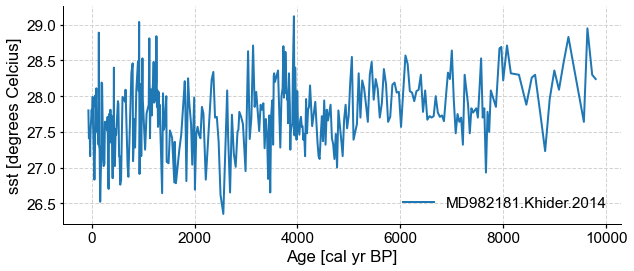

In [41]:
ts.plot()

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [cal yr BP]', ylabel='sst [degrees Celcius]'>)

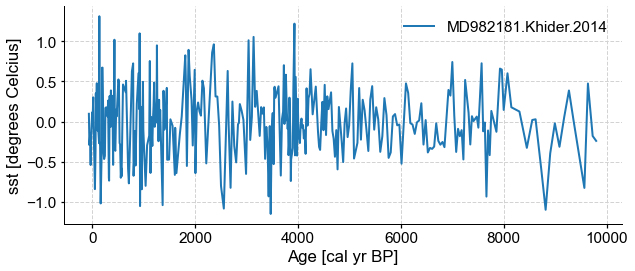

In [42]:
ts_detrended=ts.detrend(n=2)
ts_detrended.plot()

Optimizing for the best number of clusters, this may take a few minutes


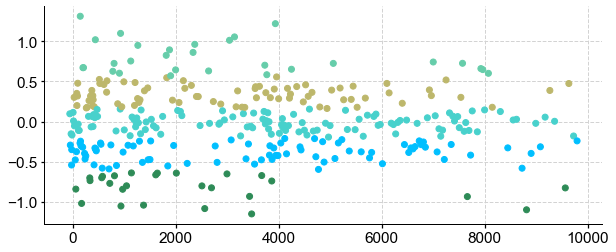

In [49]:
indices,res = detect_outliers_kmeans(ts_detrended.value)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts_detrended.time, ts_detrended.value, clusters, indices, figsize=[10,4])

In [22]:
res

,number of clusters,silhouette score,outlier indices
0,2,0.522023,[]
1,3,0.537490,[]
2,4,0.532683,[]
3,5,0.556463,[]
4,6,0.542312,[]
5,7,0.533937,[]
6,8,0.544673,[]
7,9,0.547792,[]
8,10,0.547201,[]


Optimizing for the best number of clusters, this may take a few minutes


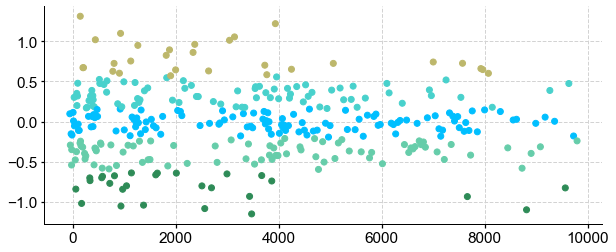

In [50]:
indices,res = detect_outliers_kmeans(ts_detrended.value, threshold=2)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts_detrended.time, ts_detrended.value, clusters, indices, figsize=[10,4])

In [51]:
res

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.521662,"[21, 201]","[0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, ..."
1,3,0.537813,[],"[2, 0, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0, 0, 1, 2, ..."
2,4,0.532683,[],"[2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 3, 0, 1, 2, ..."
3,5,0.556463,[],"[1, 2, 1, 2, 2, 1, 1, 1, 4, 1, 2, 3, 2, 4, 4, ..."
4,6,0.543926,[],"[0, 4, 0, 4, 4, 0, 1, 0, 1, 0, 4, 2, 4, 1, 1, ..."
5,7,0.532282,[],"[4, 0, 0, 3, 0, 0, 4, 4, 2, 4, 3, 5, 0, 2, 2, ..."
6,8,0.545456,[],"[7, 1, 3, 4, 1, 3, 7, 3, 0, 3, 4, 5, 1, 0, 7, ..."
7,9,0.548951,[],"[0, 5, 8, 1, 5, 8, 0, 8, 2, 8, 1, 7, 5, 2, 0, ..."
8,10,0.546087,[],"[9, 4, 3, 1, 4, 3, 9, 9, 0, 3, 1, 5, 4, 6, 0, ..."


Optimizing for the best number of clusters, this may take a few minutes


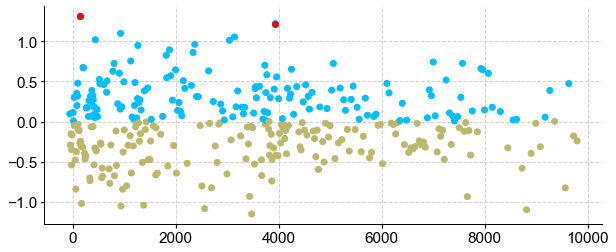

In [52]:
indices,res = detect_outliers_kmeans(ts_detrended.value, threshold=2, nbr_cluster=2)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts_detrended.time, ts_detrended.value, clusters, indices, figsize=[10,4])

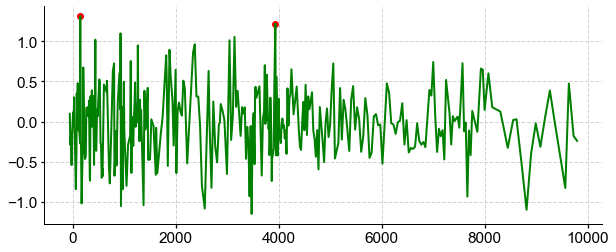

In [53]:
plot_outliers(ts_detrended.time,ts_detrended.value,indices)

In [30]:
indices,res = detect_outliers_kmeans(ts_detrended.value, threshold=1, nbr_cluster=2)

Optimizing for the best number of clusters, this may take a few minutes


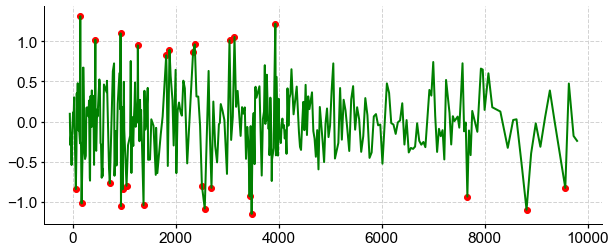

In [31]:
plot_outliers(ts_detrended.time,ts_detrended.value,indices)

### GISP2 d18O

In [55]:
df = pd.read_csv('GISP2_Deglacial.csv')
df

,Age [yr BP],d18O [per mil]
0,10014.2,-34.59
1,10038.0,-35.45
2,10061.5,-35.61
3,10084.5,-35.57
4,10109.4,-34.65
...,...,...
209,23303.0,-38.31
210,23406.0,-40.08
211,23528.0,-41.58
212,23656.0,-41.91


In [56]:
ts=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='d18O',
                time_unit='yr BP', value_unit='per mil')

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [yr BP]', ylabel='d18O [per mil]'>)

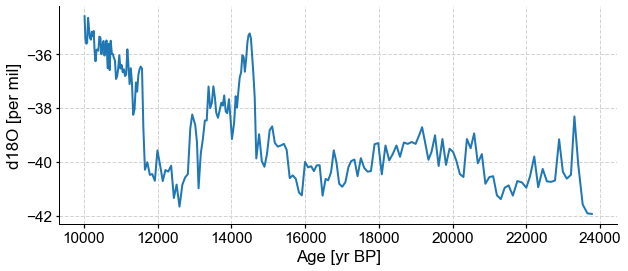

In [57]:
ts.plot()

Optimizing for the best number of clusters, this may take a few minutes


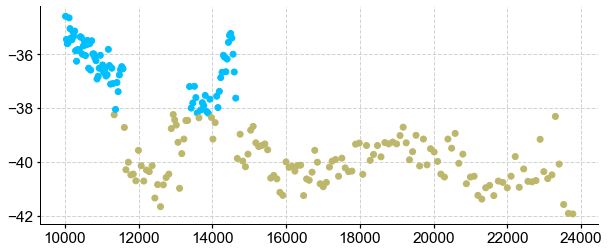

In [61]:
indices,res = detect_outliers_kmeans(ts.value)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts.time, ts.value, clusters, indices, figsize=[10,4])

In [62]:
res

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.687672,[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,3,0.615668,[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,4,0.569457,[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,5,0.558632,[],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, ..."
4,6,0.544034,[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, ..."
5,7,0.563535,[],"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, ..."
6,8,0.555686,[],"[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ..."
7,9,0.570966,[],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, ..."
8,10,0.563352,[],"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 8, 8, 8, 8, ..."


### LR04

In [64]:
df = pd.read_csv('LR04.csv',skiprows=4)
df

,Time (ka),Benthic d18O (per mil),Standard error (per mil)
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03
...,...,...,...
2110,5300.0,2.91,0.06
2111,5305.0,2.79,0.04
2112,5310.0,2.79,0.09
2113,5315.0,2.84,0.07


In [65]:
ts=pyleo.Series(time = df.iloc[:,0], value = df.iloc[:,1],
                time_name = 'Age', value_name='benthic d18O',
                time_unit='ks', value_unit='per mil')

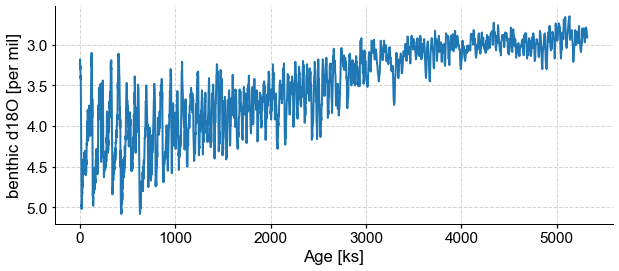

In [67]:
fig,ax = ts.plot()
ax.invert_yaxis()

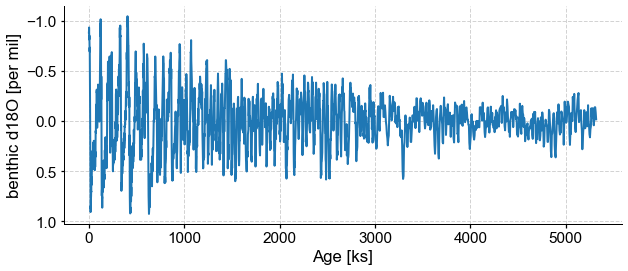

In [68]:
ts_detrended = ts.detrend()
fig,ax = ts_detrended.plot()
ax.invert_yaxis()

Optimizing for the best number of clusters, this may take a few minutes


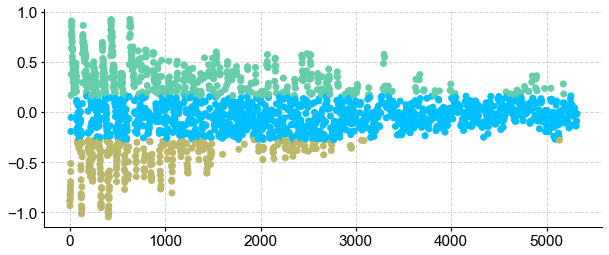

In [69]:
indices,res = detect_outliers_kmeans(ts_detrended.value)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts_detrended.time, ts_detrended.value, clusters, indices, figsize=[10,4])

## Using the clustering method to ID anomalies

In [70]:
D = pyleo.Lipd('Zhang.Hulu.2014.lpd')

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Zhang.Hulu.2014.lpd
Finished read: 1 record


In [71]:
ts=D.to_LipdSeries()

extracting paleoData...
extracting: Zhang.Hulu.2014
Created time series: 5 entries
0 :  Zhang.Hulu.2014 :  Speleothem :  Depth
1 :  Zhang.Hulu.2014 :  Speleothem :  age
2 :  Zhang.Hulu.2014 :  Speleothem :  D18O
3 :  Zhang.Hulu.2014 :  Speleothem :  D13C
4 :  Zhang.Hulu.2014 :  Speleothem :  Event_0


Enter the number of the variable you wish to use:  2


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [year BP]', ylabel='D18O [permil VPDB]'>)

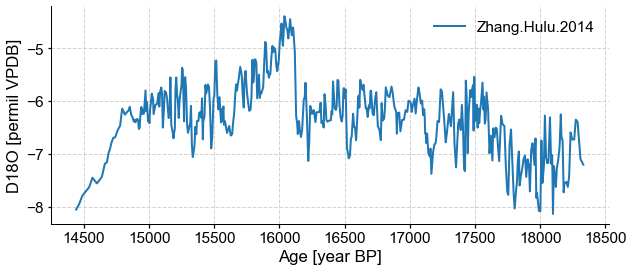

In [72]:
ts.plot()

Optimizing for the best number of clusters, this may take a few minutes


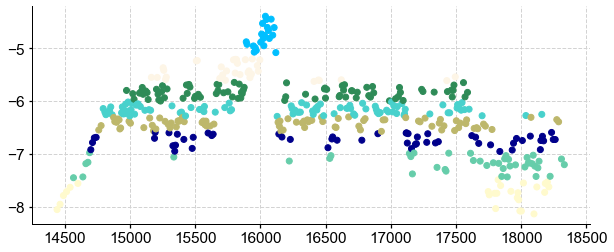

In [73]:
indices,res = detect_outliers_kmeans(ts.value)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts.time, ts.value, clusters, indices, figsize=[10,4])

In [76]:
res

,number of clusters,silhouette score,outlier indices,clusters
0,2,0.524322,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,3,0.550070,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, ..."
2,4,0.548618,[],"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
3,5,0.560455,[],"[1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, ..."
4,6,0.559447,[],"[2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 0, 0, 0, ..."
5,7,0.552074,[],"[6, 6, 6, 6, 6, 3, 6, 3, 3, 3, 3, 3, 0, 0, 0, ..."
6,8,0.568260,[],"[6, 6, 6, 6, 6, 2, 6, 2, 2, 2, 2, 7, 7, 7, 7, ..."
7,9,0.563901,[],"[5, 5, 5, 5, 5, 1, 5, 1, 1, 1, 1, 8, 8, 8, 8, ..."
8,10,0.561393,[],"[7, 7, 7, 7, 1, 1, 1, 1, 9, 9, 9, 4, 4, 4, 4, ..."


Optimizing for the best number of clusters, this may take a few minutes


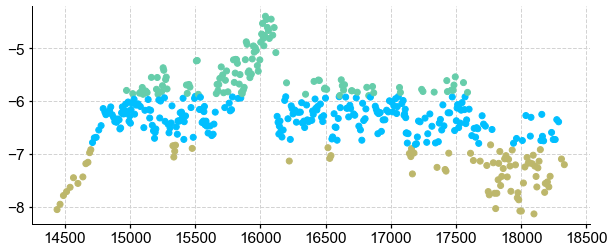

In [77]:
indices,res = detect_outliers_kmeans(ts.value, nbr_cluster = 3)
clusters = np.array(res.loc[res['silhouette score']==np.max(res['silhouette score'])]['clusters'])[0]
plot_clusters(ts.time, ts.value, clusters, indices, figsize=[10,4])

In [74]:
event = D.to_LipdSeries(number=4)

extracting paleoData...
extracting: Zhang.Hulu.2014
Created time series: 5 entries


(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:xlabel='Age [year BP]', ylabel='Event_0 [NA]'>)

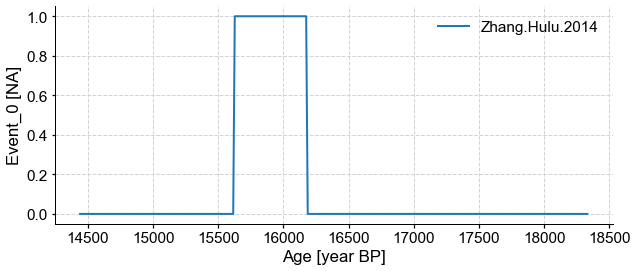

In [75]:
event.plot()